<a href="https://colab.research.google.com/github/nhuang37/aut_GNN/blob/main/Equivariant_project_subgroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from torch.nn import Parameter, ParameterList
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import symbols, simplify

#### Use sympy to compute close-form symbolic expression for
- $\Psi_{S_3}(\Theta)$
- $\Psi_{S_3}^{\perp}(\Theta)$

In [2]:
#The standard representation of S3 on R^3 by permuting coordinates
S3_std = [
    np.array([[1,0,0],[0,1,0],[0,0,1]]).T,
    np.array([[0,1,0],[1,0,0],[0,0,1]]).T,
    np.array([[0,0,1],[0,1,0],[1,0,0]]).T,
    np.array([[1,0,0],[0,0,1],[0,1,0]]).T,
    np.array([[0,1,0],[0,0,1],[1,0,0]]).T,
    np.array([[0,0,1],[1,0,0],[0,1,0]]).T,
]

In [3]:
#dim of S3-equiv space
dim_S3_equiv = np.array([np.trace(m) * np.trace(m) for m in S3_std]).sum()/6
dim_S3_equiv

2.0

In [4]:
def proj_S3(Theta, S3_std):
  return np.array([ out_m @ Theta @ in_m.T for out_m, in_m in zip(S3_std, S3_std)]).mean(axis=0)

In [5]:
# S3_R2 = [
#     np.array([[1,0],[0,1]]),
#     np.array([[-1,0],[0,1]]),
#     0.5 * np.array([[1, -np.sqrt(3)],
#                     [-np.sqrt(3), -1]]),
#     0.5 * np.array([[1, np.sqrt(3)],
#                     [np.sqrt(3), -1]]),
#     0.5 * np.array([[-1, np.sqrt(3)],
#                     [-np.sqrt(3), -1]]),
#     0.5 * np.array([[-1, -np.sqrt(3)],
#                     [np.sqrt(3), -1]]),
# ]

In [6]:
a, b, c, d, e = symbols('a b c d e')
Theta = np.array([
    [a, b, c],
    [b, a, c],
    [d, d, e]
])
# Theta = np.array([
#     [a, b, b],
#     [b, a, a],
#     [b, b, a]
# ])
Theta

array([[a, b, c],
       [b, a, c],
       [d, d, e]], dtype=object)

In [7]:
Theta_S3proj = proj_S3(Theta, S3_std)
Theta_S3proj

array([[2*a/3 + e/3, b/3 + c/3 + d/3, b/3 + c/3 + d/3],
       [b/3 + c/3 + d/3, 2*a/3 + e/3, b/3 + c/3 + d/3],
       [b/3 + c/3 + d/3, b/3 + c/3 + d/3, 2*a/3 + e/3]], dtype=object)

In [8]:
Theta_S3perp = Theta - Theta_S3proj
Theta_S3perp

array([[a/3 - e/3, 2*b/3 - c/3 - d/3, -b/3 + 2*c/3 - d/3],
       [2*b/3 - c/3 - d/3, a/3 - e/3, -b/3 + 2*c/3 - d/3],
       [-b/3 - c/3 + 2*d/3, -b/3 - c/3 + 2*d/3, -2*a/3 + 2*e/3]],
      dtype=object)

In [9]:
simplify(np.trace(Theta_S3proj.T @ (Theta_S3perp))) #wohoooooo

0

In [10]:
bias = simplify(np.trace(Theta_S3perp.T @ Theta_S3perp)) #norm of perp
bias

2*(a - e)**2/3 + 2*(-2*b + c + d)**2/9 + 2*(b - 2*c + d)**2/9 + 2*(b + c - 2*d)**2/9

### Simulation: $f: R^3 \to R^3$, $G = S_3$, subgroups $S_2$ and trivial group. 
- vary the number of samples $n=50, 100, 200, 500$


In [11]:
#src: adapated from https://github.com/nhuang37/dimensionality_reduction/blob/main/Projections.ipynb

def make_beta(p, group):
    '''
    Return the true coefficient with a constant norm 1
    p: number of covariates (features)
    group: "S3" (return all ones beta); "S2" ([1,1,c]); "I" random sample from normal, "S2-3": all ones with the last cor + epsilon
    '''
    np.random.seed(0)
    if group == "I": #(isotropic case)
      beta = np.random.normal(size=(p,p))
    else:
      a, b, c, d, e = np.random.normal(size=5)
      if group == "S2":
        beta = np.array([[a,b,c],
                      [b,a,c],
                      [d,d,e]])
      elif group == "S3":
        beta = np.array([[a,b,b],
                        [b,a,b],
                        [b,b,a]])
      else: 
        beta = np.array([[a,b,b*0.92],
                        [b,a,b*0.92],
                        [b*0.92,b*0.92,a*0.92]])
    
    return beta / np.linalg.norm(beta)

def make_data(beta, n, sigma, seed=0, pytorch=False):
    '''
    Return the training data tuple (Y, X): Y \in \R^{n x p}, X \in \R^{n x p}
    beta: true param
    n: number of training examples
    sigma: noise standard deviation
    '''
    np.random.seed(seed)
    p = beta.shape[0]
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=np.eye(p), size=n)
    noise = np.random.normal(loc=0, scale=sigma, size=(n,p))
    Y = X @ beta + noise
    if pytorch:
      return torch.FloatTensor(Y), torch.FloatTensor(X)
    else:
      return Y, X

In [12]:
def train_test_data_torch(Ntrial, n, n_test, p, beta, SNR):
  np.random.seed(8675309 + 1)
  # compute noise std
  sigma = float(np.linalg.norm(beta)/SNR)
  print(sigma)
  # make maximal train and test sets
  X_MC = torch.zeros((Ntrial, n, p))
  Y_MC = torch.zeros((Ntrial, n, p))
  for trial in range(Ntrial):
    Y_MC[trial], X_MC[trial] = make_data(beta, n, sigma, seed=trial, pytorch=True)

  X_tests = torch.zeros((Ntrial, n_test, p))
  Y_tests = torch.zeros((Ntrial, n_test, p))
  for trial in range(Ntrial):
    Y_tests[trial], X_tests[trial] = make_data(beta, n_test, sigma, seed=n_test + trial, pytorch=True)
  
  return Y_MC, X_MC, Y_tests, X_tests, beta, SNR, sigma


def train_test_data(Ntrial, n, n_test, p, beta, SNR):
  np.random.seed(8675309 + 1)
  # compute noise std
  sigma = np.linalg.norm(beta)/SNR
  print(sigma)
  # make maximal train and test sets
  X_MC = np.zeros((Ntrial, n, p))
  Y_MC = np.zeros((Ntrial, n, p))
  for trial in range(Ntrial):
    Y_MC[trial], X_MC[trial] = make_data(beta, n, sigma, seed=trial)

  X_tests = np.zeros((Ntrial, n_test, p))
  Y_tests = np.zeros((Ntrial, n_test, p))
  for trial in range(Ntrial):
    Y_tests[trial], X_tests[trial] = make_data(beta, n_test, sigma, seed=n_test + trial)
  
  return Y_MC, X_MC, Y_tests, X_tests, beta, SNR, sigma


In [13]:

# evaluating data points with Mean Square Error
def criterion(y_pred, y):
    return torch.mean((y_pred - y) ** 2) #mean also over feature dimension here
 
def get_lstsq(X, y, group, num_epochs=20, lr=0.1, verbose=False):
  '''
  X: data features (n by p)
  y: data labels (n by 1)
  '''
  if group == 'I': #vanilla lstsq
    w = Parameter(torch.Tensor(p,p)) #torch.empty(p, requires_grad=True) #torch.tensor(-10.0, requires_grad=True)
    torch.nn.init.uniform_(w)
    optimizer = torch.optim.SGD([w], lr=lr)


  elif group == 'S2':
    w1 = Parameter(torch.Tensor(1))
    w2 = Parameter(torch.Tensor(1))
    w3 = Parameter(torch.Tensor(1))
    w4 = Parameter(torch.Tensor(1))
    w5 = Parameter(torch.Tensor(1))
    for param in [w1, w2, w3, w4, w5]:
      torch.nn.init.uniform_(param)
    optimizer = torch.optim.SGD([w1, w2, w3, w4, w5], lr=lr)


  else: #S3
    w1 = Parameter(torch.Tensor(1))
    w2 = Parameter(torch.Tensor(1))
    for param in [w1,w2]:
      torch.nn.init.uniform_(param)
    optimizer = torch.optim.SGD([w1, w2], lr=lr)

 
  for i in range(num_epochs):
      # making predictions with forward pass
      if group == 'S2':
        w = torch.stack([torch.cat([w1, w2, w3]),
                         torch.cat([w2, w1, w3]),
                         torch.cat([w4, w4, w5])
                          ])#torch.cat([w1.expand(2),w2])
      elif group == "S3":
        w = torch.stack([torch.cat([w1, w2, w2]),
                         torch.cat([w2, w1, w2]),
                         torch.cat([w2, w2, w1])
                          ]) #w1.expand(p)
      else:
        pass
      optimizer.zero_grad()
      Y_pred = X @ w
      # calculating the loss between original and predicted data points
      loss = criterion(Y_pred, y)
      # backward pass for computing the gradients of the loss w.r.t to learnable parameters
      loss.backward()
      optimizer.step()
      # priting the values for understanding
      if verbose:
        print(f'epoch={i}, loss={loss.item():.2f}')
  return w

true graph / target function: $S_2$ (imagine a wedge)
- graph regression: observe n samples $(x_i, y_i)$ where $x_i \in R^3$ are node features, $y_i = x_i  \beta + \epsilon \in R$ are the graph level output
- vanilla LS estimator: trivial group
- $S_2$ invariant estimator
- $S_3$ invariant estimator
- compute estimators using ERM [To-Do]


In [14]:
def run_exp(Ntrial, n_max, n_test, p, beta, SNR, ns, groups):
  DS = train_test_data_torch(Ntrial, n_max, n_test, p, beta, SNR)
  Y_MC, X_MC, Y_tests, X_tests, beta, SNR, sigma = DS
  #print(Y_MC[0].shape, Y_tests[0].shape)
  results = {'I': np.zeros((Ntrial, len(ns))), 'S2': np.zeros((Ntrial, len(ns))), 'S3': np.zeros((Ntrial, len(ns)))}
  for t in range(Ntrial):
    for id, n in enumerate(ns):
      for group in groups:
        w_est = get_lstsq(X_MC[t][:n, :], Y_MC[t][:n, :], group, num_epochs=50)
        Y_test_pred = X_tests[t] @ w_est
        #print(Y_test_pred.shape, Y_tests[t].shape)
        error = criterion(Y_test_pred, Y_tests[t])
        results[group][t,id] = error.item()
  return results

In [15]:
Ntrial = 10
n_max = 50
n_test = 300
p = 3
SNR = 6
ns = np.arange(20, 80, 5) #[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
groups = ['I', 'S2', 'S3']


beta_3 = make_beta(p, group="S3")
results_S3 = run_exp(Ntrial, n_max, n_test, p, beta_3, SNR, ns, groups)

beta_23 =  make_beta(p, group="S2-3")
results_S23 = run_exp(Ntrial, n_max, n_test, p, beta_23, SNR, ns, groups)

beta_2 = make_beta(p, group="S2")
results_S2 = run_exp(Ntrial, n_max, n_test, p, beta_2, SNR, ns, groups)

beta_free = make_beta(p, group="I")
results_I = run_exp(Ntrial, n_max, n_test, p, beta_free, SNR, ns, groups)


0.16666666666666666
0.16666666666666666
0.16666666666666666
0.16666666666666666


In [16]:
def get_threshold(beta, SNR, bias):
  '''
  Compute the theoretically predicted threshold where S_3 is better than S_2 before such threshold
    S3_gain: - bias + (sigma**2)*7/n-4
    S2_gain: (sigma**2)*4/n-4
    solve for n
  '''
  sigma = float(np.linalg.norm(beta)/SNR)
  return 4 + 3*(sigma**2)/bias 



In [17]:
beta_23

array([[0.56581916, 0.12835028, 0.11808226],
       [0.12835028, 0.56581916, 0.11808226],
       [0.11808226, 0.11808226, 0.52055363]])

In [18]:
bias_actual = bias.subs([(a, beta_23[0,0]), (b, beta_23[0,1]), (c, beta_23[0,2]), (d, beta_23[2,0]), (e, beta_23[2,2])])

In [19]:
n_threshold = get_threshold(beta_23, SNR, bias_actual)
n_threshold

59.3138205931266

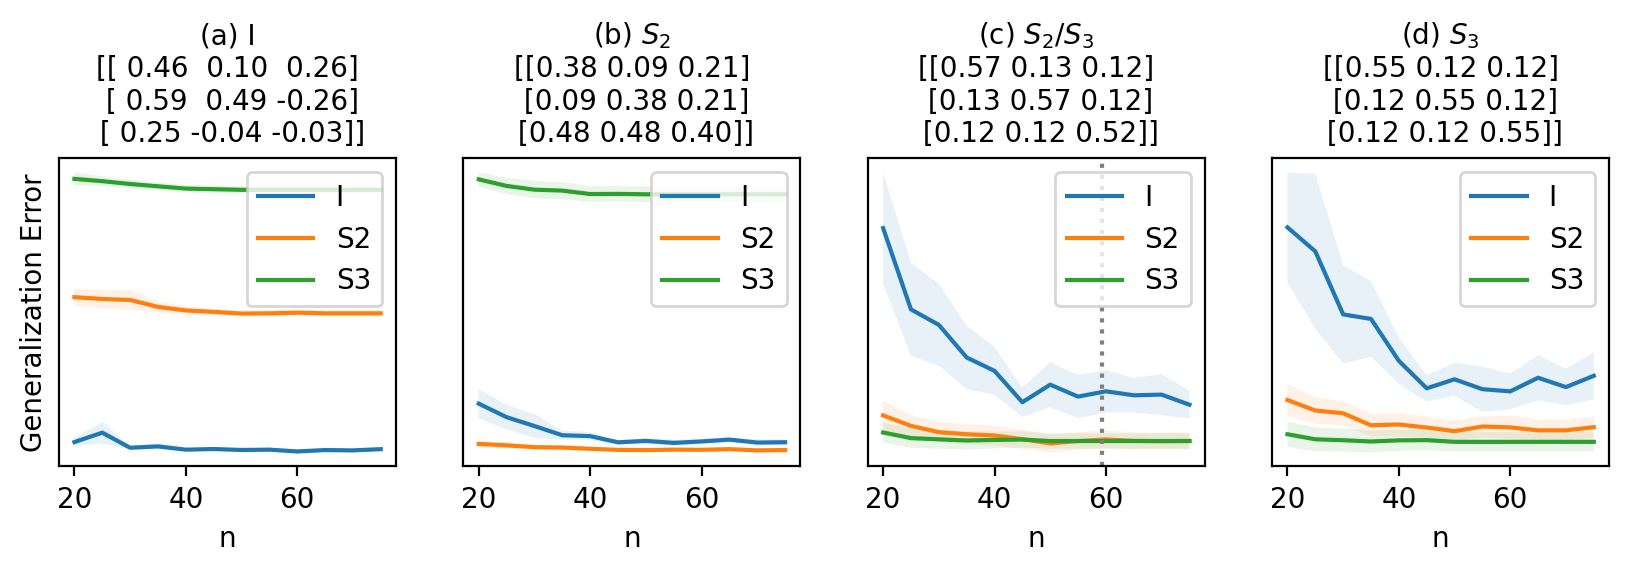

In [25]:
names = ['I', '$S_2$', '$S_2/S_3$', '$S_3$']

fig, axs = plt.subplots(ncols=4, figsize=(10,2), dpi=200)
beta_all = [beta_free, beta_2, beta_23, beta_3]
title_ids = ["(a)", "(b)", "(c)", "(d)"]
for i, results in enumerate([results_I, results_S2, results_S23, results_S3]):
  for group in groups:
    mean = results[group].mean(axis=0)
    stderr = results[group].std(axis=0)/np.sqrt(10)
    axs[i].plot(ns, mean , label=group, linewidth=1.5)
    axs[i].fill_between(ns, mean+stderr, mean-stderr, alpha=0.1)
  #ax.legend(fontsize=15)
  axs[i].set_yticks([])
  axs[i].set_xlabel("n")
  #axs[i].set_yscale("log")
  axs[i].set_title(f'{title_ids[i]} {names[i]}\n' + f"{np.array2string(beta_all[i], precision=2, floatmode='fixed')}", fontsize=10)
  axs[i].legend(loc="upper right", fontsize=10)

axs[2].axvline(x=n_threshold, linestyle=":", color="gray")
axs[0].set_ylabel("Generalization Error", rotation=90)
# for ax in axs:
#   
#plt.setp(axs[3].get_yticklabels(), visible=False)
#fig.tight_layout()
plt.show()